In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
)


In [2]:
# load data from CSV file
train_df = pd.read_csv("./dataset/HeartStudy_train.csv")
train_df.head()


,Sex,Age,SBP(mmHg),Treatment for Hypertension,Current Smoker,Diabetes,HDL,TCL,Risk
0,Female,74.0,113.0,Yes,Yes,No,66.0,135,Intermediate Risk (≥7.5% - <20%)
1,Male,69.0,93.0,No,No,Yes,48.0,374,High Risk (≥20%)
2,Female,43.0,94.0,No,No,No,83.0,315,Low Risk (<5%)
3,Female,63.0,140.0,No,Yes,Yes,14.0,195,High Risk (≥20%)
4,Female,67.0,NaN,Yes,No,Yes,34.0,275,High Risk (≥20%)


### Datatype and Shape
Shape of given dataset and each column type

In [3]:
train_df.shape


(10115, 9)

The dataset contains 10115 data and 9 columns with a target column.

In [4]:
train_df.dtypes


Sex                            object
Age                           float64
SBP(mmHg)                     float64
Treatment for Hypertension     object
Current Smoker                 object
Diabetes                       object
HDL                           float64
TCL                             int64
Risk                           object
dtype: object

### Target column

In [5]:
train_df["Risk"].nunique()


4

In [6]:
train_df["Risk"].unique()


array(['Intermediate Risk (≥7.5% - <20%)', 'High Risk (≥20%)',
       'Low Risk (<5%)', 'Borderline Risk (>5% - <7.5%)'], dtype=object)

Target column 'Risk' contain 4 classes.

### Duplicate Data

In [7]:
train_df.duplicated().value_counts()


False    7047
True     3068
Name: count, dtype: int64

Given dataset contain duplicated value which is not needed to train model so remove duplicate rows

In [8]:
train_df.drop_duplicates(inplace=True)


### NULL value in dataset
Check the presence of Null in the data

In [9]:
train_df.isna().sum()


Sex                           0
Age                           0
SBP(mmHg)                     7
Treatment for Hypertension    0
Current Smoker                0
Diabetes                      0
HDL                           4
TCL                           0
Risk                          0
dtype: int64

Data contain more than 7000 rows and the null in the dataset is very less as compared to the data so we can remove the null row.

In [10]:
train_df.dropna(inplace=True)
train_df.shape


(7036, 9)

### Statistics
View the mean, standard deviation, min, and max of the numeric columns in the dataset.

In [11]:
train_df.describe().loc[["mean", "std", "min", "max"]]


,Age,SBP(mmHg),HDL,TCL
mean,52.020196,144.497868,54.578454,251.891984
std,13.317745,32.656449,26.309177,88.345950
min,-74.000000,22.000000,10.000000,100.000000
max,170.000000,200.000000,100.000000,405.000000


By looking Statistics table, we can conclude that the Age column contains outliers. As Age cannot be negative.

### Box plot
View outliers

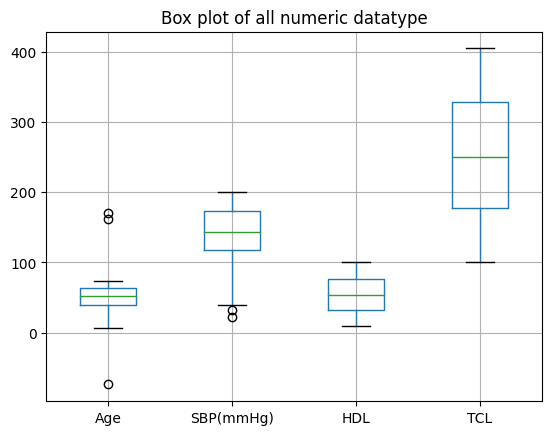

In [12]:
train_df.boxplot()
plt.title("Box plot of all numeric datatype")
plt.show()


- With the help of a box plot we can conclude that columns like Age and SBP(mmHg) contain some outliers.
- The age column has outliers that some have to remove as age cannot be negative and people usually live up to 100 years.
- SBP column also contains outliers but outliers value may happen in real life.
- So, we will remove outliers of the Age column only

Remove outliers from age column

In [13]:
train_df = train_df[(train_df["Age"] >= 0) & (train_df["Age"] < 100)]
train_df.shape


(7033, 9)

Remove row from data whose Age contains a negative value and Age greater than 100 years.

### View Dataset

Gender

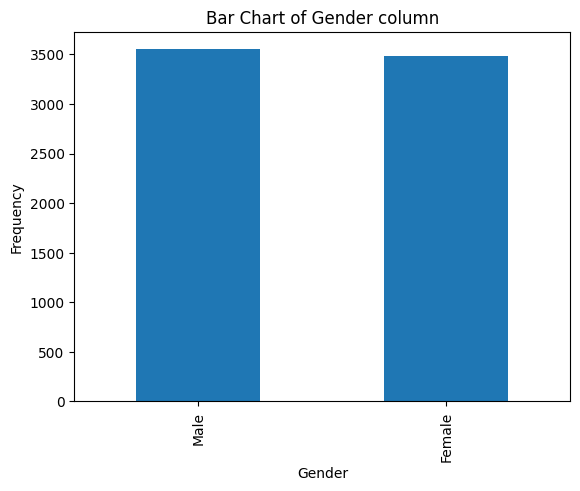

In [14]:
train_df["Sex"].value_counts().plot(kind="bar")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.title("Bar Chart of Gender column")
plt.show()


Male      0.504901

Female    0.495099

The dataset contains about the same number of Male and Female population.

which gender have high risk?

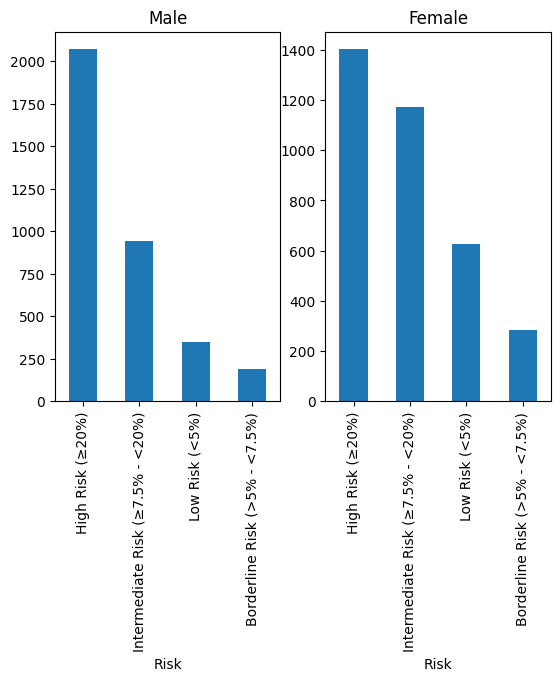

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
(train_df["Risk"][train_df["Sex"] == "Male"].value_counts().plot(kind="bar", ax=ax1))
(train_df["Risk"][train_df["Sex"] == "Female"].value_counts().plot(kind="bar", ax=ax2))
ax1.set_title("Male")
ax2.set_title("Female")
plt.show()


The data sets contain almost equal amounts of male and female data for different classes of risk but the majority class is high-risk, so it is best to use one hot encoder rather than a label encoder.

Bar chart of target column

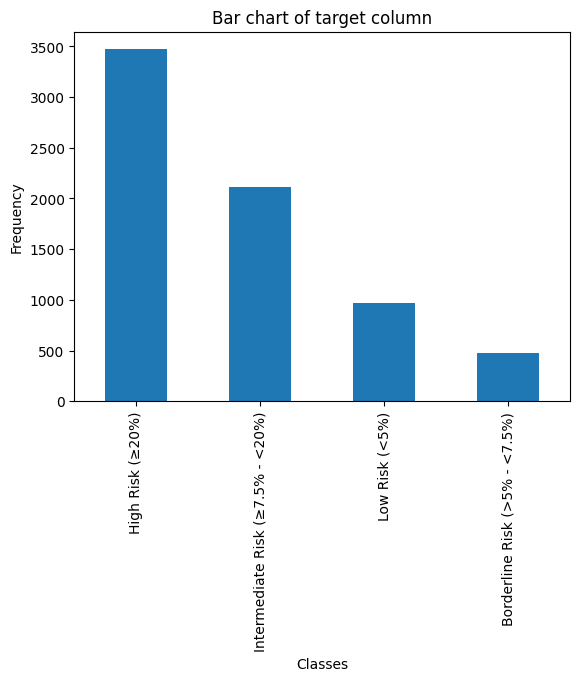

In [16]:
train_df["Risk"].value_counts().plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Bar chart of target column")
plt.show()


High Risk (≥20%)                    0.496683

Intermediate Risk (≥7.5% - <20%)    0.298782

Low Risk (<5%)                      0.137709

Borderline Risk (>5% - <7.5%)       0.066825

The given data set look imbalance data as High Risk class contain 49.6% of data where Borderling Risk contain 6.68% data

Bar chart 

Current Smoker has high risk?

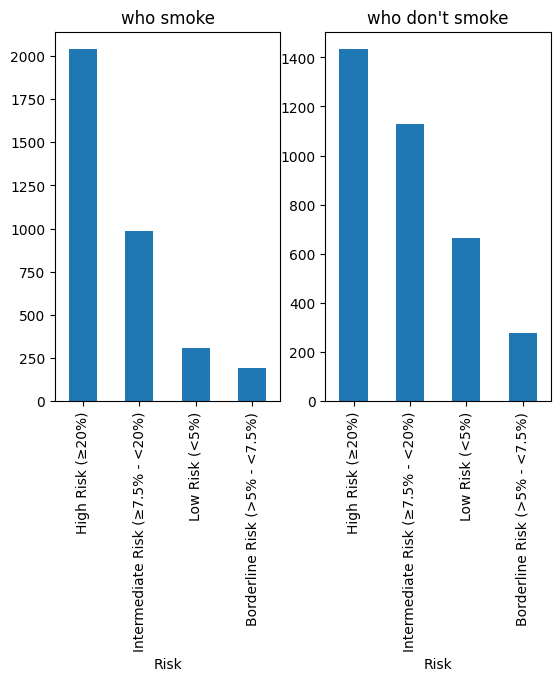

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
(
    train_df["Risk"][train_df["Current Smoker"] == "Yes"]
    .value_counts()
    .plot(kind="bar", ax=ax1)
)
(
    train_df["Risk"][train_df["Current Smoker"] == "No"]
    .value_counts()
    .plot(kind="bar", ax=ax2)
)
ax1.set_title("who smoke")
ax2.set_title("who don't smoke")
plt.show()


- From the bar chart, we can conclude that smoking or not smoking doesn't determine the Risk class.
- But smokers have a high risk as per the given data.

### Encoding
Encode category datatype column.
making 

- For other

	0 : No
	
	1: Yes

- Target Classification :

	0: Low Risk (<5%)

	1: Borderline Risk (>5% - <7.5%)

	2: Intermediate Risk (≥7.5% - <20%)
	 
	3: High Risk (≥20%)

In [18]:
label_encoding_column = [
    column
    for column in train_df.drop(columns=["Sex"]).columns
    if train_df[column].nunique() == 2
]
train_df[label_encoding_column] = train_df[label_encoding_column].apply(
    LabelEncoder().fit_transform
)


In [19]:
train_df.head()


,Sex,Age,SBP(mmHg),Treatment for Hypertension,Current Smoker,Diabetes,HDL,TCL,Risk
0,Female,74.0,113.0,1,1,0,66.0,135,Intermediate Risk (≥7.5% - <20%)
1,Male,69.0,93.0,0,0,1,48.0,374,High Risk (≥20%)
2,Female,43.0,94.0,0,0,0,83.0,315,Low Risk (<5%)
3,Female,63.0,140.0,0,1,1,14.0,195,High Risk (≥20%)
5,Male,66.0,184.0,1,0,1,44.0,404,High Risk (≥20%)


In [20]:
# target_class = {
# 	'Low Risk (<5%)': 0,
# 	'Borderline Risk (>5% - <7.5%)': 1,
# 	'Intermediate Risk (≥7.5% - <20%)': 2,
# 	'High Risk (≥20%)': 3
# }
# train_df.replace(target_class, inplace = True)


### Correlation

making encoding column datatype as numeric to find correlation.

In [21]:
for column in train_df.drop(columns=["Sex", "Risk"]).columns:
    if train_df[column].nunique() < 5:
        train_df[column] = train_df[column].astype("int")


In [22]:
### Correlation
correlation = train_df.drop(columns="Risk").corr(numeric_only=True)


In [23]:
correlation


,Age,SBP(mmHg),Treatment for Hypertension,Current Smoker,Diabetes,HDL,TCL
Age,1.000000,0.002710,-0.010728,-0.007778,0.004332,-0.009674,0.022907
SBP(mmHg),0.002710,1.000000,-0.001649,0.000181,0.012776,0.015010,-0.036106
Treatment for Hypertension,-0.010728,-0.001649,1.000000,0.014946,0.001483,0.020221,-0.002439
Current Smoker,-0.007778,0.000181,0.014946,1.000000,-0.019418,0.003742,-0.022026
Diabetes,0.004332,0.012776,0.001483,-0.019418,1.000000,0.003551,-0.020515
HDL,-0.009674,0.015010,0.020221,0.003742,0.003551,1.000000,0.009320
TCL,0.022907,-0.036106,-0.002439,-0.022026,-0.020515,0.009320,1.000000


Heatmap of correlation

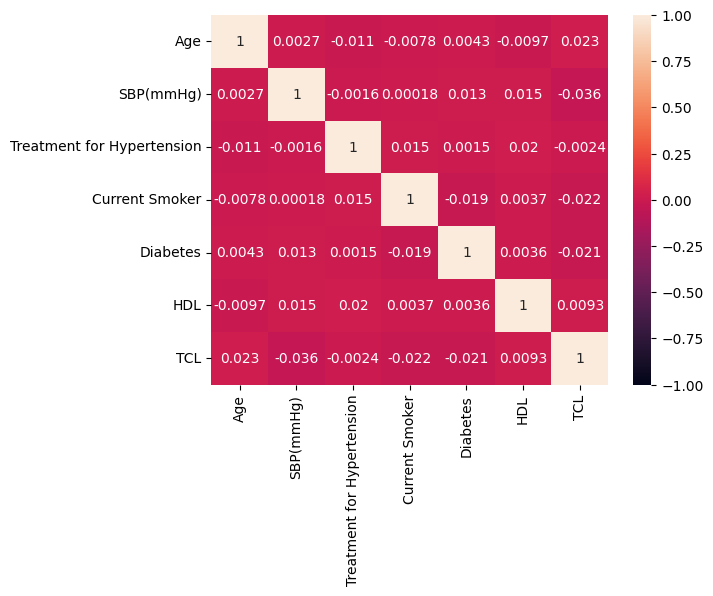

In [24]:
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1)
plt.show()


From the correlation value of numeric data, we can conclude that feature columns are not highly correlated.

### Category datatype
Convert categorical data to category datatype.

In [25]:
for column in train_df.columns:
    if train_df[column].nunique() < 5:
        train_df[column] = train_df[column].astype("category")


Columns with a number of unique values less than 5 consider categorical data.

In [26]:
train_df.dtypes


Sex                           category
Age                            float64
SBP(mmHg)                      float64
Treatment for Hypertension    category
Current Smoker                category
Diabetes                      category
HDL                            float64
TCL                              int64
Risk                          category
dtype: object

Convert all categorical column to category datatype.

### Pipeline
Make pipeline with OneHotEncoder, MinMaxScaler and classification

Seperate Feature column and Target column

In [27]:
X = train_df.drop(columns="Risk")
y = train_df["Risk"]


In [28]:
numeric_column = train_df.select_dtypes("number").columns
category_column = ["Sex"]
column_trans = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(), category_column),
        ("Normalization", MinMaxScaler(), numeric_column),
    ]
)
model = Pipeline(
    [
        ("transformer", column_trans),
        ("DecisionTree", DecisionTreeClassifier()),
    ]
)


### Train and Predict the training dataset

Fit data into the pipeline

In [29]:
model.fit(X, y)


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['Sex']),
                                                 ('Normalization',
                                                  MinMaxScaler(),
                                                  Index(['Age', 'SBP(mmHg)', 'HDL', 'TCL'], dtype='object'))])),
                ('DecisionTree', DecisionTreeClassifier())])

Predict training dataset to view metrics.

In [30]:
y_pred = model.predict(X)


In [31]:
y_pred_pro = model.predict_proba(X)


### Metrics

Confusion matrix

In [32]:
ConfusionMatrix = confusion_matrix(y, y_pred)


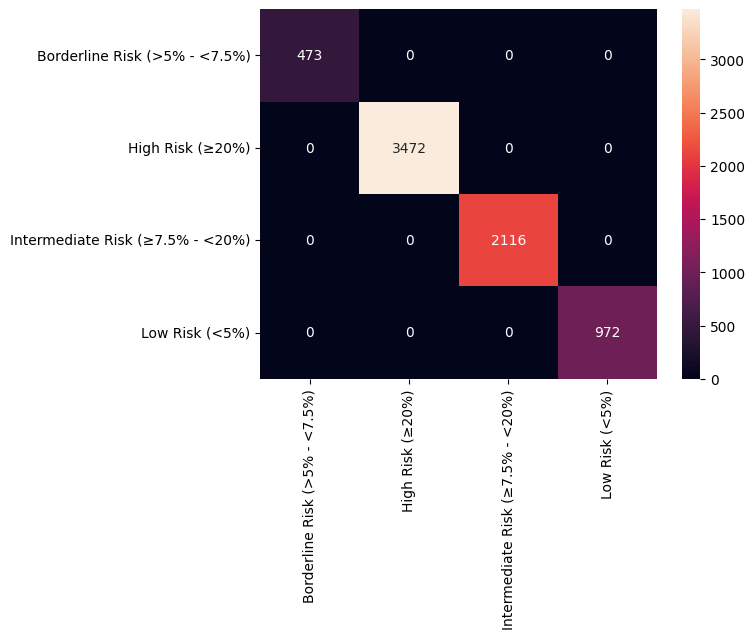

In [33]:
labels = list(train_df["Risk"].unique())
labels.sort()
sns.heatmap(
    ConfusionMatrix,
    annot=True,
    fmt=".4g",
    xticklabels=labels,
    yticklabels=labels,
)
plt.show()


- From the confusion matrix, the model trains very well on training data.
- So there is a high chance of overfitting.

Other metrics

In [34]:
print("Model accuracy:", accuracy_score(y, y_pred))


Model accuracy: 1.0


Model accuracy is very high so there is a high chance of overfitting.
So let's view the recall, Precision, and F1 score of the model.

In [35]:
model_precision, model_recall, model_f1_score, _ = precision_recall_fscore_support(
    y, y_pred, average="macro"
)
print("Model precision:", model_precision)
print("Model recall:", model_recall)
print("Model f1-score:", model_f1_score)


Model precision: 1.0
Model recall: 1.0
Model f1-score: 1.0


Check metrics say the model train is perfect for training dataso let's check the test data on the model to verify model is not overfitting.

---

### Model Test

Applying the Same data processing on test data which is inside preprocessing function.

In [36]:
def preprocessing(df):
    df.drop_duplicates(inplace=True)

    df.dropna(inplace=True)

    df = df[(df["Age"] >= 0) & (df["Age"] < 100)]

    label_encoding_column = [
        column
        for column in df.drop(columns=["Sex"]).columns
        if df[column].nunique() == 2
    ]
    df[label_encoding_column] = train_df[label_encoding_column].apply(
        LabelEncoder().fit_transform
    )

    for column in df.columns:
        if df[column].nunique() < 5:
            df[column] = df[column].astype("category")

    return df


In [37]:
# load data from CSV file
test_df = pd.read_csv("./dataset/HeartStudy_test.csv")
test_df.head()


,Sex,Age,SBP(mmHg),Treatment for Hypertension,Current Smoker,Diabetes,HDL,TCL,Risk
0,Male,67,97,No,No,Yes,32,379,High Risk (≥20%)
1,Male,38,102,Yes,Yes,Yes,16,228,High Risk (≥20%)
2,Female,53,109,Yes,No,Yes,13,180,Intermediate Risk (≥7.5% - <20%)
3,Male,73,137,Yes,Yes,Yes,39,145,High Risk (≥20%)
4,Female,72,182,No,Yes,Yes,76,230,High Risk (≥20%)


In [38]:
test_df = preprocessing(test_df)
test_df.head()


,Sex,Age,SBP(mmHg),Treatment for Hypertension,Current Smoker,Diabetes,HDL,TCL,Risk
0,Male,67,97,1.0,1.0,0.0,32,379,High Risk (≥20%)
1,Male,38,102,0.0,0.0,1.0,16,228,High Risk (≥20%)
2,Female,53,109,0.0,0.0,0.0,13,180,Intermediate Risk (≥7.5% - <20%)
3,Male,73,137,0.0,1.0,1.0,39,145,High Risk (≥20%)
4,Female,72,182,NaN,NaN,NaN,76,230,High Risk (≥20%)


In [39]:
X_test = test_df.drop(columns="Risk")
y_test = test_df["Risk"]


In [40]:
y_pred_test = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)


In [41]:
ConfusionMatrix = confusion_matrix(y_test, y_pred_test)


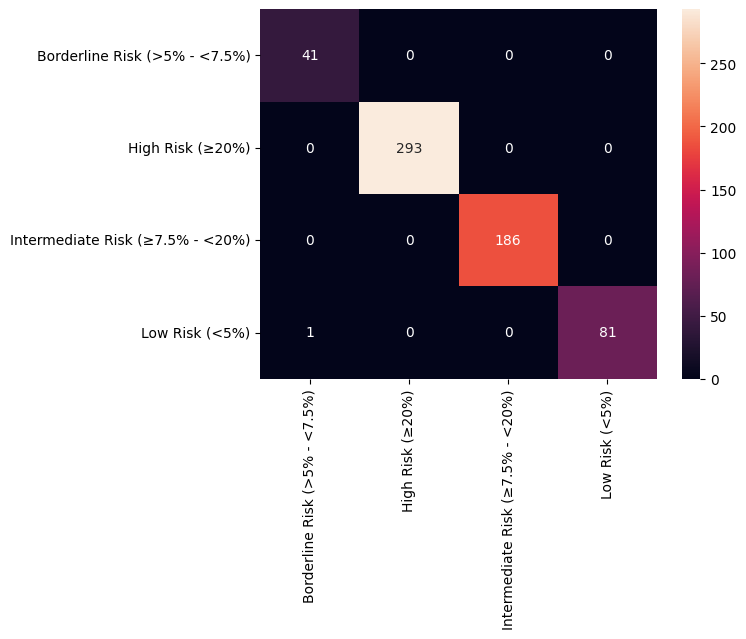

In [42]:
labels = list(test_df["Risk"].unique())
labels.sort()
sns.heatmap(
    ConfusionMatrix,
    annot=True,
    fmt=".4g",
    xticklabels=labels,
    yticklabels=labels,
)
plt.show()


In [43]:
print("Model accuracy:", accuracy_score(y_test, y_pred_test))


Model accuracy: 0.9983388704318937


In [44]:
model_precision, model_recall, model_f1_score, _ = precision_recall_fscore_support(
    y_test, y_pred_test, average="macro"
)
print("Model precision:", model_precision)
print("Model recall:", model_recall)
print("Model f1-score:", model_f1_score)


Model precision: 0.9940476190476191
Model recall: 0.9969512195121951
Model f1-score: 0.9954542094759405


In [45]:
roc_auc_score(y_test, y_test_prob, labels=labels, multi_class="ovr", average="macro")


0.9982527933568106

The model works very well for unseen data so we can say that model is not overfitting but the data is too easy for a model to classify.